# Torch Runtime

In this tutorial, we introduce Torch Runtime, and show how to use it via the `TorchRuntimeClient` class in Qiskit Machine Learning.
Torch Runtime leverages Qiskit Runtime for 
hybrid quantum-classical machine learning based on a PyTorch `Module`. It allows training models or predicting the outputs with trained models significantly faster. We show how to use Torch RUntime with two simple examples for regression and classification tasks in the following.

## 1. Regression

First, we show how to use Torch Runtime via `TorchRuntimeClient` using the simple regression example. In the example, we will perform 
a regression task on a randomly generated dataset following a sin wave.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, manual_seed, is_tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult


# Set seed for random generators
seed = 42
manual_seed(seed)
algorithm_globals.random_seed = seed

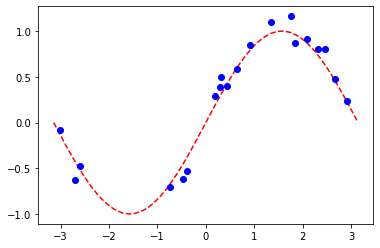

In [2]:
# Generate random dataset for the training
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)
X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X) + eps*(2*np.random.rand(num_samples, 1)-1)

plt.figure()
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')
plt.plot(X, y, 'bo')
plt.show()


`TorchRuntimeClient` requires a PyTorch `DataLoader` as an input for training/predicting. For that purpose, we create a custom torch dataset class.

In [3]:
# Create custom torch dataset class
class TorchDataset(Dataset):

    """Map-style dataset"""
    def __init__(self, X, y):
        self.X = Tensor(X).float()
        self.y = Tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i

# Create a train loader
train_set = TorchDataset(X,y)
train_loader1 = DataLoader(train_set, batch_size=1, shuffle=False)

Create a PyTorch model, and set up an optimizer and a loss function as usual.

In [70]:
from qiskit.circuit import Parameter

# Construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter('y')
ansatz = QuantumCircuit(1, name='vf')
ansatz.ry(param_y, 0)

# Construct QNN
qnn1 = TwoLayerQNN(1, feature_map, ansatz)
print(qnn1.operator)


initial_weights = 0.1*(2*algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights)

# Define optimizer and loss function
optimizer1 = Adam(model1.parameters(), lr=0.1) 
loss_func1 = MSELoss(reduction='sum')

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


Load a provider and specify a backend for the runtime service. 

In [71]:
# Set up a provider and backend
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(project='default') 
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2021-11-23 17:58:02,876: Credentials are already in use. The existing account in the session will be replaced.


Create a Torch Runtime Client instance with the model, the optimizer, and other configurations.

In [72]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer1,
                                        loss_func=loss_func1,
                                        epochs=5,
                                        backend=backend,
                                    )

### `fit()` to train the model
Call `fit` method in `TorchRuntimeClient` with the data loader to train the model.

In [73]:
fit_result = torch_runtime_client.fit(train_loader = train_loader1)

----------------
Following cells are added temporarily since we can not have the real torch runtime in the server-side yet.

In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
!docker cp ../src/torch_train.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"epoch": 0, "training loss": 0.6519502907991409, "validation loss": null, "average forward pass time": 0.0082527756690979, "average backward pass time": 0.09519320726394653, "epoch_time": 2.0871570110321045}
{"epoch": 1, "training loss": 0.02747313145573571, "validation loss": null, "average forward pass time": 0.00427790880203247, "average backward pass time": 0.08873833417892456, "epoch_time": 1.8773951530456543}
{"epoch": 2, "training loss": 0.02125945960287936, "validation loss": null, "average forward pass time": 0.004361844062805176, "average backward pass time": 0.09340013265609741, "epoch_time": 1.9725890159606934}
{"epoch": 3, "training loss

In [11]:
from qiskit_machine_learning.runtime import str_to_obj

result_ = {"model_state_dict": "gASV5QIAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEP/gAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADkzOTE4MjMwMDY4MTkycQJYAwAAAGNwdXEDSwFOdHEEUS6AAl1xAFgOAAAAOTM5MTgyMzAwNjgxOTJxAWEuAQAAAAAAAAC5mci/lIWUUpRLAEsBhZRLAYWUiWgCKVKUdJRSlIwIX3dlaWdodHOUaAcoaApD/4ACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5MzkxODIzMDA2ODE5MnECWAMAAABjcHVxA0sBTnRxBFEugAJdcQBYDgAAADkzOTE4MjMwMDY4MTkycQFhLgEAAAAAAAAAuZnIv5SFlFKUSwBLAYWUSwGFlIloAilSlHSUUpR1fZSMCV9tZXRhZGF0YZRoAilSlIwAlH2UjAd2ZXJzaW9ulEsBc3NzYi4=", "train_history": {"train": [{"epoch": 0, "loss": 0.6287885455414652, "forward_time": 0.007128441333770752, "backward_time": 0.07493594884872437, "epoch_time": 1.6558871269226074}, {"epoch": 1, "loss": 0.03379448799387319, "forward_time": 0.003424859046936035, "backward_time": 0.07277388572692871, "epoch_time": 1.5375840663909912}, {"epoch": 2, "loss": 0.01828708676819133, "forward_time": 0.00335996150970459, "backward_time": 0.0689307451248169, "epoch_time": 1.4592063426971436}, {"epoch": 3, "loss": 0.012518359369278188, "forward_time": 0.0033134341239929197, "backward_time": 0.06696546077728271, "epoch_time": 1.418945550918579}, {"epoch": 4, "loss": 0.013881158554022477, "forward_time": 0.003410661220550537, "backward_time": 0.0689520001411438, "epoch_time": 1.4610049724578857}], "validation": []}, "execution_time": 7.533513307571411}

torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

fit_result = TorchRuntimeResult()
fit_result.job_id = 12345
fit_result.train_history = result_["train_history"]["train"]
fit_result.execution_time = result_["execution_time"]
fit_result.model_state_dict = str_to_obj(result_["model_state_dict"])

-------------------

You can access the information about the training result via `TorchRuntimeResult` class. Also, model's parameters in `TorchRuntimeClient` are updated with trained ones. 

In [12]:
print('id: ', fit_result.job_id)
print('execution time: ', fit_result.execution_time)
print('train history: ', fit_result.train_history)
print('model_state_dict: ', torch_runtime_client.model.state_dict())


id:  12345
execution time:  7.533513307571411
train history:  [{'epoch': 0, 'loss': 0.6287885455414652, 'forward_time': 0.007128441333770752, 'backward_time': 0.07493594884872437, 'epoch_time': 1.6558871269226074}, {'epoch': 1, 'loss': 0.03379448799387319, 'forward_time': 0.003424859046936035, 'backward_time': 0.07277388572692871, 'epoch_time': 1.5375840663909912}, {'epoch': 2, 'loss': 0.01828708676819133, 'forward_time': 0.00335996150970459, 'backward_time': 0.0689307451248169, 'epoch_time': 1.4592063426971436}, {'epoch': 3, 'loss': 0.012518359369278188, 'forward_time': 0.0033134341239929197, 'backward_time': 0.06696546077728271, 'epoch_time': 1.418945550918579}, {'epoch': 4, 'loss': 0.013881158554022477, 'forward_time': 0.003410661220550537, 'backward_time': 0.0689520001411438, 'epoch_time': 1.4610049724578857}]
model_state_dict:  OrderedDict([('weight', tensor([-1.5672])), ('_weights', tensor([-1.5672]))])


#### Training with validation
Torch Runtime can also perform the validation while training a model by passing a validation data loader to `fit` method.

In [15]:
# Create a validation dataloader
X_test = [[x] for x in np.linspace(lb, ub)]
y_test = [[y] for y in f(np.linspace(lb, ub))]
test_set = TorchDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [16]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer1,
                                        loss_func=loss_func1,
                                        epochs=5,
                                        backend=backend,
                                    )

In [18]:
# Pass a train data loader and a validation data loader
fit_result = torch_runtime_client.fit(train_loader = train_loader1, val_loader=test_loader)

-------

In [19]:
result_ = {"model_state_dict": "gASV5QIAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEP/gAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADk0NzkxMzQwNjQ2MTQ0cQJYAwAAAGNwdXEDSwFOdHEEUS6AAl1xAFgOAAAAOTQ3OTEzNDA2NDYxNDRxAWEuAQAAAAAAAABJiMi/lIWUUpRLAEsBhZRLAYWUiWgCKVKUdJRSlIwIX3dlaWdodHOUaAcoaApD/4ACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NDc5MTM0MDY0NjE0NHECWAMAAABjcHVxA0sBTnRxBFEugAJdcQBYDgAAADk0NzkxMzQwNjQ2MTQ0cQFhLgEAAAAAAAAASYjIv5SFlFKUSwBLAYWUSwGFlIloAilSlHSUUpR1fZSMCV9tZXRhZGF0YZRoAilSlIwAlH2UjAd2ZXJzaW9ulEsBc3NzYi4=", "train_history": {"train": [{"epoch": 0, "loss": 0.600094748660922, "forward_time": 0.007148647308349609, "backward_time": 0.07085573673248291, "epoch_time": 1.57456374168396}, {"epoch": 1, "loss": 0.030057143244448525, "forward_time": 0.0016440868377685547, "backward_time": 0.0693540096282959, "epoch_time": 1.4341495037078857}, {"epoch": 2, "loss": 0.02533961619716365, "forward_time": 0.0033911705017089845, "backward_time": 0.06918885707855224, "epoch_time": 1.4652225971221924}, {"epoch": 3, "loss": 0.013602298773093935, "forward_time": 0.003237760066986084, "backward_time": 0.06664506196975709, "epoch_time": 1.4105041027069092}, {"epoch": 4, "loss": 0.015099877770990134, "forward_time": 0.0032798171043395994, "backward_time": 0.06813886165618896, "epoch_time": 1.4413228034973145}], "validation": [{"epoch": 0, "loss": 0.046238261605631124, "forward_time": 0.002290487289428711, "backward_time": 0, "epoch_time": 0.002290487289428711}, {"epoch": 1, "loss": 0.02404542155436502, "forward_time": 0.0024220943450927734, "backward_time": 0, "epoch_time": 0.0024220943450927734}, {"epoch": 2, "loss": 0.002134242930741266, "forward_time": 0.0024492740631103516, "backward_time": 0, "epoch_time": 0.0024492740631103516}, {"epoch": 3, "loss": 0.0008236507183167419, "forward_time": 0.002490520477294922, "backward_time": 0, "epoch_time": 0.002490520477294922}, {"epoch": 4, "loss": 0.0006055122900423271, "forward_time": 0.0023369789123535156, "backward_time": 0, "epoch_time": 0.0023369789123535156}]}, "execution_time": 7.9897003173828125}

torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

fit_result  = TorchRuntimeResult()
fit_result.job_id = 12345
fit_result.train_history = result_["train_history"]["train"]
fit_result.val_history = result_["train_history"]["validation"]
fit_result.execution_time = result_["execution_time"]
fit_result.model_state_dict = str_to_obj(result_["model_state_dict"])

-------

In [20]:
print('id: ', fit_result.job_id)
print('execution time: ', fit_result.execution_time)
print('train history: ', fit_result.train_history)
print('validation history: ', fit_result.val_history)

id:  12345
execution time:  7.9897003173828125
train history:  [{'epoch': 0, 'loss': 0.600094748660922, 'forward_time': 0.007148647308349609, 'backward_time': 0.07085573673248291, 'epoch_time': 1.57456374168396}, {'epoch': 1, 'loss': 0.030057143244448525, 'forward_time': 0.0016440868377685547, 'backward_time': 0.0693540096282959, 'epoch_time': 1.4341495037078857}, {'epoch': 2, 'loss': 0.02533961619716365, 'forward_time': 0.0033911705017089845, 'backward_time': 0.06918885707855224, 'epoch_time': 1.4652225971221924}, {'epoch': 3, 'loss': 0.013602298773093935, 'forward_time': 0.003237760066986084, 'backward_time': 0.06664506196975709, 'epoch_time': 1.4105041027069092}, {'epoch': 4, 'loss': 0.015099877770990134, 'forward_time': 0.0032798171043395994, 'backward_time': 0.06813886165618896, 'epoch_time': 1.4413228034973145}]
validation history:  [{'epoch': 0, 'loss': 0.046238261605631124, 'forward_time': 0.002290487289428711, 'backward_time': 0, 'epoch_time': 0.002290487289428711}, {'epoch': 

### `predict()` to perform prediction
Call `predict` method in `TorchRuntimeClient` with the data loader to perform prediction on the passed data using the trained model.

In [21]:
predict_result = torch_runtime_client.predict(data_loader = test_loader)

---------

In [22]:
result_ = {"prediction": [[[-0.041015625]], [[-0.111328125]], [[-0.26953125]], [[-0.40234375]], [[-0.482421875]], [[-0.623046875]], [[-0.71875]], [[-0.783203125]], [[-0.83984375]], [[-0.9296875]], [[-0.966796875]], [[-0.986328125]], [[-0.998046875]], [[-0.99609375]], [[-0.9765625]], [[-0.94140625]], [[-0.89453125]], [[-0.798828125]], [[-0.708984375]], [[-0.68359375]], [[-0.533203125]], [[-0.419921875]], [[-0.263671875]], [[-0.2109375]], [[-0.09375]], [[0.0859375]], [[0.162109375]], [[0.31640625]], [[0.484375]], [[0.54296875]], [[0.669921875]], [[0.736328125]], [[0.828125]], [[0.890625]], [[0.94140625]], [[0.984375]], [[0.998046875]], [[0.99609375]], [[0.994140625]], [[0.958984375]], [[0.912109375]], [[0.845703125]], [[0.759765625]], [[0.681640625]], [[0.599609375]], [[0.474609375]], [[0.36328125]], [[0.2890625]], [[0.171875]], [[0.0234375]]], "execution_time": 0.2320547103881836}

predict_result = TorchRuntimeResult()
predict_result.job_id = 123
predict_result.prediction = Tensor(result_["prediction"])
predict_result.execution_time = result_["execution_time"]

---------

In [23]:
print('id: ', predict_result.job_id)
print('execution time: ', predict_result.execution_time)

id:  123
execution time:  0.2320547103881836


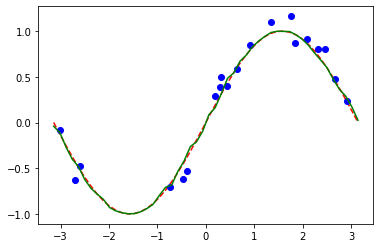

In [38]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')

# Plot data
plt.plot(X, y, 'bo')
# # Plot fitted line
y_ = []
for output in predict_result.prediction:
    y_.append(output.item())
plt.plot(X_test, y_, 'g-')

plt.show()

### `score()` to calculate a score
Call `score` method in `TorchRuntimeClient` with the data loader to calculate a score 
for the trained model. You can pass `"regression"` and `"classification"` to `score_func` argument for the pre-defined score functions. Alos, you can pass a custom scoring function defined as: 
```
def score_func(model_output, target): -> score: float
```

Note that the result of `score` also contain the prediction result that was calculated in the process of calculating the score.

In [39]:
score_result = torch_runtime_client.score(data_loader = test_loader, score_func = "regression")

------

In [40]:
result_ = {"score": 0.0006100250769480908, "prediction": [[[-0.0078125]], [[-0.134765625]], [[-0.32421875]], [[-0.373046875]], [[-0.4921875]], [[-0.59765625]], [[-0.736328125]], [[-0.814453125]], [[-0.849609375]], [[-0.927734375]], [[-0.962890625]], [[-0.9921875]], [[-1.0]], [[-0.98828125]], [[-0.970703125]], [[-0.953125]], [[-0.865234375]], [[-0.7890625]], [[-0.69921875]], [[-0.61328125]], [[-0.5625]], [[-0.4765625]], [[-0.345703125]], [[-0.185546875]], [[-0.03515625]], [[0.083984375]], [[0.236328125]], [[0.32421875]], [[0.42578125]], [[0.56640625]], [[0.662109375]], [[0.775390625]], [[0.8125]], [[0.884765625]], [[0.947265625]], [[0.970703125]], [[0.99609375]], [[0.99609375]], [[0.986328125]], [[0.9609375]], [[0.90625]], [[0.841796875]], [[0.794921875]], [[0.708984375]], [[0.59765625]], [[0.4296875]], [[0.427734375]], [[0.27734375]], [[0.099609375]], [[0.029296875]]], "execution_time": 0.31411170959472656}

In [41]:
score_result = TorchRuntimeResult()
score_result.job_id = 123
score_result.prediction = Tensor(result_["prediction"])
score_result.score = result_["score"]
score_result.execution_time = result_["execution_time"]

-------

In [42]:
print('id: ', score_result.job_id)
print('execution time: ', score_result.execution_time)
print('score: ', score_result.score)



id:  123
execution time:  0.31411170959472656
score:  0.0006100250769480908


## 2. Classification

Second, we show how to perform a simple classification task using Torch Runtime. In the example, we will perform binary classification on a randomly generated dataset.

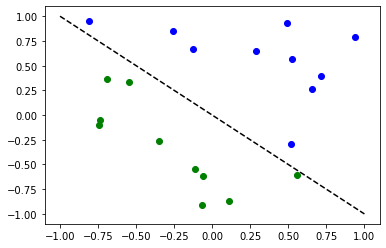

In [43]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2*algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2*y01-1                       # in {-1, +1}, y will be used for OplowQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [44]:
# Create custom torch dataset class
class TorchDataset(Dataset):

    """Map-style dataset"""
    def __init__(self, X, y):
        self.X = Tensor(X)
        self.y = Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i

In [45]:
y = y.reshape(20,1)
train_set = TorchDataset(X,y)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)

In [46]:
# Set up QNN
qnn = TwoLayerQNN(num_qubits=num_inputs)
print(qnn.operator)

# Set up PyTorch module
initial_weights = 0.1*(2*algorithm_globals.random.random(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_1: ┤1                                                         ├
  «     └──────────────────────────────────────────────────────────┘
  )
])
Initial weights:  [ 0.04005302 -0.03752667  0.06645196  0.06095287 -0.02250432 -0.04233438
  0.0364991  -0.0720495 ]


In [47]:
# Define optimizer and loss
optimizer = Adam(model.parameters(), lr=0.1) 
loss_func = MSELoss(reduction='sum')

In [48]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=5,
                                        backend=backend,
                                        )

### `fit()` to train the model

In [49]:
train_result = torch_runtime_client.fit(train_loader = train_loader, seed=42)

---

In [50]:
result_ = {"model_state_dict": "gASVIwMAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEIbAQAAgAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADk0Nzc2MzQzMTA3NjQ4cQJYAwAAAGNwdXEDSwhOdHEEUS6AAl1xAFgOAAAAOTQ3NzYzNDMxMDc2NDhxAWEuCAAAAAAAAACmgJc/aQKLvrAPAL91qWg/tRtCPx3vib66Wii/tUWJP5SFlFKUSwBLCIWUSwGFlIloAilSlHSUUpSMCF93ZWlnaHRzlGgHKGgKQhsBAACAAooKbPycRvkgaqhQGS6AAk3pAy6AAn1xAChYEAAAAHByb3RvY29sX3ZlcnNpb25xAU3pA1gNAAAAbGl0dGxlX2VuZGlhbnECiFgKAAAAdHlwZV9zaXplc3EDfXEEKFgFAAAAc2hvcnRxBUsCWAMAAABpbnRxBksEWAQAAABsb25ncQdLBHV1LoACKFgHAAAAc3RvcmFnZXEAY3RvcmNoCkZsb2F0U3RvcmFnZQpxAVgOAAAAOTQ3NzYzNDMxMDc2NDhxAlgDAAAAY3B1cQNLCE50cQRRLoACXXEAWA4AAAA5NDc3NjM0MzEwNzY0OHEBYS4IAAAAAAAAAKaAlz9pAou+sA8Av3WpaD+1G0I/He+JvrpaKL+1RYk/lIWUUpRLAEsIhZRLAYWUiWgCKVKUdJRSlHV9lIwJX21ldGFkYXRhlGgCKVKUjACUfZSMB3ZlcnNpb26USwFzc3NiLg==", "train_history": {"train": [{"epoch": 0, "loss": 1.192161750793457, "forward_time": 0.008829903602600098, "backward_time": 0.15732910633087158, "epoch_time": 3.3365063667297363}, {"epoch": 1, "loss": 0.7761648178100586, "forward_time": 0.004354143142700195, "backward_time": 0.14646663665771484, "epoch_time": 3.029676914215088}, {"epoch": 2, "loss": 0.7771394729614258, "forward_time": 0.004325389862060547, "backward_time": 0.14366017580032348, "epoch_time": 2.972076654434204}, {"epoch": 3, "loss": 0.803067970275879, "forward_time": 0.004159808158874512, "backward_time": 0.14785971641540527, "epoch_time": 3.0526950359344482}, {"epoch": 4, "loss": 0.8006114959716797, "forward_time": 0.0044343829154968265, "backward_time": 0.14634374380111695, "epoch_time": 3.0279295444488525}], "validation": []}, "execution_time": 15.419778823852539}


torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

fit_result = TorchRuntimeResult()
fit_result.job_id = 12345
fit_result.train_history = result_["train_history"]["train"]
fit_result.execution_time = result_["execution_time"]
fit_result.model_state_dict = str_to_obj(result_["model_state_dict"])

---

In [51]:
print('id: ', fit_result.job_id)
print('execution time: ', fit_result.execution_time)
print('train history: ', fit_result.train_history)
print('validation history: ', fit_result.val_history)

id:  12345
execution time:  15.419778823852539
train history:  [{'epoch': 0, 'loss': 1.192161750793457, 'forward_time': 0.008829903602600098, 'backward_time': 0.15732910633087158, 'epoch_time': 3.3365063667297363}, {'epoch': 1, 'loss': 0.7761648178100586, 'forward_time': 0.004354143142700195, 'backward_time': 0.14646663665771484, 'epoch_time': 3.029676914215088}, {'epoch': 2, 'loss': 0.7771394729614258, 'forward_time': 0.004325389862060547, 'backward_time': 0.14366017580032348, 'epoch_time': 2.972076654434204}, {'epoch': 3, 'loss': 0.803067970275879, 'forward_time': 0.004159808158874512, 'backward_time': 0.14785971641540527, 'epoch_time': 3.0526950359344482}, {'epoch': 4, 'loss': 0.8006114959716797, 'forward_time': 0.0044343829154968265, 'backward_time': 0.14634374380111695, 'epoch_time': 3.0279295444488525}]
validation history:  None


### `predict()` to perform prediction

In [52]:
# In this example, we use the same data loader for the prediction as well
predict_result = torch_runtime_client.predict(data_loader = train_loader)

---

In [53]:
!docker cp ../src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py



/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"prediction": [[[-0.001953125]], [[0.150390625]], [[0.0703125]], [[-0.103515625]], [[0.615234375]], [[0.232421875]], [[-0.275390625]], [[-0.53515625]], [[0.23828125]], [[-0.30859375]], [[0.31640625]], [[-0.2109375]], [[-0.412109375]], [[0.4140625]], [[0.26171875]], [[0.0859375]], [[-0.3828125]], [[-0.240234375]], [[-0.033203125]], [[0.83203125]]], "execution_time": 0.1928863525390625}


In [54]:
result_ = {"prediction": [[[0.03125]], [[0.083984375]], [[0.052734375]], [[-0.16015625]], [[0.6484375]], [[0.189453125]], [[-0.306640625]], [[-0.50390625]], [[0.228515625]], [[-0.3046875]], [[0.291015625]], [[-0.23828125]], [[-0.431640625]], [[0.40625]], [[0.224609375]], [[0.0703125]], [[-0.34375]], [[-0.27734375]], [[-0.001953125]], [[0.84765625]]], "execution_time": 0.20331740379333496}

predict_result = TorchRuntimeResult()
predict_result.job_id = 123
predict_result.prediction = Tensor(result_["prediction"])
predict_result.execution_time = result_["execution_time"]

---

In [55]:
print('id: ', predict_result.job_id)
print('execution time: ', predict_result.execution_time)

id:  123
execution time:  0.20331740379333496


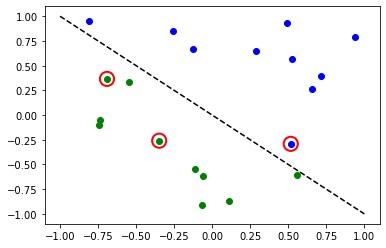

In [56]:
# Plot results
# red == wrongly classified

y_predict = []
for out in predict_result.prediction:
    y_predict += [np.sign(out.item())]
y_predict = np.array(y_predict)
y_check = [i[0] for i in y]

for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()


The red circles indicate wrongly classified data points.

### `score()` to calculate a score

In the example, we use the following custom scoring function to calculate a score. The scoring function returns 1, if the trained model successfully classify the input. Otherwise, it returns 0. An overall average is calculated in `score()` in the end.

In [57]:
def score_func(out, target):
    from numpy import sign
    score = 0
    if sign(out.item()) == target.item():
        score = 1
    return score


In [58]:
score_result = torch_runtime_client.score(data_loader=train_loader, score_func=score_func)

----

In [59]:
!docker cp ../src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"score": 0.85, "prediction": [[[0.021484375]], [[0.080078125]], [[0.021484375]], [[-0.146484375]], [[0.681640625]], [[0.228515625]], [[-0.298828125]], [[-0.498046875]], [[0.294921875]], [[-0.353515625]], [[0.333984375]], [[-0.2734375]], [[-0.412109375]], [[0.419921875]], [[0.267578125]], [[0.1015625]], [[-0.416015625]], [[-0.294921875]], [[-0.0234375]], [[0.85546875]]], "execution_time": 0.18293190002441406}


In [60]:
result_ = {"score": 0.85, "prediction": [[[0.0078125]], [[0.109375]], [[0.056640625]], [[-0.126953125]], [[0.662109375]], [[0.19140625]], [[-0.2578125]], [[-0.5390625]], [[0.294921875]], [[-0.33984375]], [[0.31640625]], [[-0.234375]], [[-0.369140625]], [[0.408203125]], [[0.201171875]], [[0.013671875]], [[-0.365234375]], [[-0.265625]], [[-0.029296875]], [[0.8671875]]], "execution_time": 0.2116398811340332}


score_result = TorchRuntimeResult()
score_result.job_id = 123
score_result.prediction = Tensor(result_["prediction"])
score_result.score = result_["score"]
score_result.execution_time = result_["execution_time"]

----

In [61]:
print('id: ', score_result.job_id)
print('execution time: ', score_result.execution_time)
print('score: ', score_result.score)

id:  123
execution time:  0.2116398811340332
score:  0.85


## 3. How to use hooks in training
Qiskit Machine Learning offers a base hook class, `HookBase`. It is a base class for a hook that is a set of callback functions used in the training process. Users can implement their own hook classes from this base class to handle complicated callback processes. This structure provides high flexibility in the callback processes.
Each hook can implement 6 methods, and each method is called before/after the corresponding processes during training. The way they are called is demonstrated
in the following snippet:
```
    hook.before_train()
    for epoch in range(epochs):
        hook.before_epoch()
        for batch in train_loader:
            hook.before_step()
            train_step()
            hook.after_step()
            global_step += 1
        hook.after_epoch()
        epoch += 1
    hook.after_train()
```

In the hook methods, users can access `TorchTrainer` via `self.trainer` to access more properties about the context (e.g., model, current iteration, or config). The following snippet describes the accessible variables that are useful for a hook.

- TorchTrainer
  - model: A model to be trained.
  - optimizer: An optimizer used for the training.
  - loss_func: A loss function for the training.
  - train_loader: A PyTorch data loader object containing a training dataset.
  - val_loader: A PyTorch data loader object containing a validation dataset.
  - max_epoch: The maximum number of training epochs.
  - log_period: A logging period for a train history and a validation history. By default,
                there will be logs every epoch (`log_period`=1).
  - start_epoch: An initial epoch for warm-start training. By default, 0.
  - epoch: The current number of epochs.
  - global_step: The current number of steps.
  - train_logger: A logger for a training history. Use `train_logger.metrics` to access a list of logs. A log for each epoch is stored as a dictionary similar to `TorchRuntimeResult.train_history`
  - val_logger: A logger for a validation history. Logs are stored in the same way as train_logger.

 Users can pass a single hook instance or a list of hook instances to `hooks` argument.


The following example is a hook for early stopping. If the current loss is smaller than the threshold after an epoch, the training will be terminated. 

In [76]:
from qiskit_machine_learning.runtime import HookBase

class StopHook(HookBase):
    """
    For early stopping
    """

    def __init__(self, loss_threshold):
        self._loss_threshold = loss_threshold

    def after_epoch(self):
        # This function is called after each epoch
        current_loss = self.trainer.train_logger.metrics[-1]["loss"]
        print('current loss: ', current_loss)
        # If current loss is smaller than the threshold,
        # set the current number of the epoch to the maximum number of the epochs to stop the training
        if current_loss < self._loss_threshold:
            self.trainer.epoch = self.trainer.max_epochs

stop_hook = StopHook(loss_threshold=0.05) 


In [77]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer1,
                                        loss_func=loss_func1,
                                        epochs=5,
                                        backend=backend,
                                        )

In [79]:
fit_result = torch_runtime_client.fit(train_loader=train_loader1, hooks=stop_hook)

----

In [80]:
!docker cp ../src/torch_train.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"epoch": 0, "training loss": 0.6607211172115057, "validation loss": null, "average forward pass time": 0.009653174877166748, "average backward pass time": 0.10987980365753174, "epoch_time": 2.4111807346343994}
current loss:  0.6607211172115057
{"epoch": 1, "training loss": 0.032746360854980595, "validation loss": null, "average forward pass time": 0.004878580570220947, "average backward pass time": 0.10419203042984009, "epoch_time": 2.200406551361084}
current loss:  0.032746360854980595
{"model_state_dict": "gASV5QIAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdl

In [81]:
result_ = {"model_state_dict": "gASV5QIAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEP/gAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADk0ODUyMzIzMjcxMjgwcQJYAwAAAGNwdXEDSwFOdHEEUS6AAl1xAFgOAAAAOTQ4NTIzMjMyNzEyODBxAWEuAQAAAAAAAAA6weS/lIWUUpRLAEsBhZRLAYWUiWgCKVKUdJRSlIwIX3dlaWdodHOUaAcoaApD/4ACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NDg1MjMyMzI3MTI4MHECWAMAAABjcHVxA0sBTnRxBFEugAJdcQBYDgAAADk0ODUyMzIzMjcxMjgwcQFhLgEAAAAAAAAAOsHkv5SFlFKUSwBLAYWUSwGFlIloAilSlHSUUpR1fZSMCV9tZXRhZGF0YZRoAilSlIwAlH2UjAd2ZXJzaW9ulEsBc3NzYi4=", "train_history": {"train": [{"epoch": 0, "loss": 0.6218201427720487, "forward_time": 0.008634221553802491, "backward_time": 0.09483517408370971, "epoch_time": 2.088063955307007}, {"epoch": 1, "loss": 0.03179714586731279, "forward_time": 0.004410469532012939, "backward_time": 0.09125356674194336, "epoch_time": 1.9302630424499512}], "validation": []}, "execution_time": 4.018845796585083}

torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

fit_result = TorchRuntimeResult()
fit_result.job_id = 12345
fit_result.train_history = result_["train_history"]["train"]
fit_result.execution_time = result_["execution_time"]
fit_result.model_state_dict = str_to_obj(result_["model_state_dict"])


----

In [82]:
print('id: ', fit_result.job_id)
print('execution time: ', fit_result.execution_time)
print('train history: ', fit_result.train_history)
print('model_state_dict: ', torch_runtime_client.model.state_dict())


id:  12345
execution time:  4.018845796585083
train history:  [{'epoch': 0, 'loss': 0.6218201427720487, 'forward_time': 0.008634221553802491, 'backward_time': 0.09483517408370971, 'epoch_time': 2.088063955307007}, {'epoch': 1, 'loss': 0.03179714586731279, 'forward_time': 0.004410469532012939, 'backward_time': 0.09125356674194336, 'epoch_time': 1.9302630424499512}]
model_state_dict:  OrderedDict([('weight', tensor([-1.7871])), ('_weights', tensor([-1.7871]))])


As we can see, the training finished before reaching to the 5th epoch. 